**Name:** Maria Master

**Class:** INST 447 Spring 2024

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Programming Assignment 2

**Research Question:** Is there an association between average household income and service requests? What is the relationship between average household income and non-parking related service requests? What is the relationship between average household income and parking related service requests?

**Data Source**: Open Data DC

1. Data 

DC is divided into 8 geographic units called wards. These wards have different demographics, socioeconomic status, density, etc. The US Census Bureau collects data on the U.S. population using the the American Community Survey. Open Data DC reports specific 311 service request data in DC and the economic status of these wards. 

In [2]:
# read file
request_df = pd.read_csv('data/311_City_Service_Requests_in_2020.csv')
request_df.head(2)

/var/folders/2n/bvbzz2f14hl7rv0l62pzp_c80000gn/T/ipykernel_43364/3757498511.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv('data/311_City_Service_Requests_in_2020.csv')


,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,...,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED
0,-77.062247,38.971951,9272477,C62313,Christmas Tree Removal-Seasonal,SWMA- Solid Waste Management Admistration,DPW,1,2020/01/03 14:15:00+00,2020/01/22 16:30:22+00,...,20015.0,260261.0,4,NaN,NaN,{9B922E97-CDB6-E4E4-E053-532F520A122A},NaN,NaN,NaN,NaN
1,-77.064789,38.904953,9272478,DMV01,DMV - Drivers License/ID Issues,Driver Vehicle Services,DMV,1,2020/01/07 15:06:11+00,2020/01/10 14:13:28+00,...,20007.0,279688.0,2,NaN,NaN,{9B922E97-CDB7-E4E4-E053-532F520A122A},NaN,NaN,NaN,NaN


2. Cleaning 

**Level 1**

Level 1 cleaning deals with the basics of data cleaning where we clean up our dataframe. By the end of Level 1 cleaning, we should have a standard data structure, attributes with codeable and intuitive column names and rows with a unique identifier. 
Our Level 1 cleaning would include:
- renaming columns
- correcting data types 
- dropping insignificant columns

*Level 1 Cleaning - requests*

In [3]:
request_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305555 entries, 0 to 305554
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   X                           305555 non-null  float64
 1   Y                           305555 non-null  float64
 2   OBJECTID                    305555 non-null  int64  
 3   SERVICECODE                 305555 non-null  object 
 4   SERVICECODEDESCRIPTION      305555 non-null  object 
 5   SERVICETYPECODEDESCRIPTION  302193 non-null  object 
 6   ORGANIZATIONACRONYM         305421 non-null  object 
 7   SERVICECALLCOUNT            305555 non-null  int64  
 8   ADDDATE                     305555 non-null  object 
 9   RESOLUTIONDATE              303658 non-null  object 
 10  SERVICEDUEDATE              299872 non-null  object 
 11  SERVICEORDERDATE            305555 non-null  object 
 12  INSPECTIONFLAG              0 non-null       float64
 13  INSPECTIONDATE

In [4]:
# make columns names legible
for column in request_df.columns:
    new_column_name = column.capitalize()
    request_df.rename(columns={column: new_column_name}, inplace=True)

In [5]:
# drop columns
request_df.drop(['State','Zipcode','Servicetypecodedescription','Servicecallcount','Globalid','City','Priority','Servicerequestid','Serviceorderdate','Serviceduedate','Servicecode','Creator','Created','Editor','Edited','Longitude','Latitude','Ycoord','Xcoord','Streetaddress','Inspectorname','X','Y','Objectid','Organizationacronym','Inspectionflag','Inspectiondate','Details','Maraddressrepositoryid','Gis_id','Status_code'], axis=1, inplace=True)

In [6]:
# rename columns
new_request_df = request_df.copy()
new_column_names = {
    'Servicecodedescription': 'Service_code_description',
    'Adddate': 'Date_added',
    'Resolutiondate': 'Date_resolved',
    'Serviceorderstatus':'Service_order_status'
}

new_request_df.rename(columns=new_column_names, inplace=True)

new_request_df.head()

,Service_code_description,Date_added,Date_resolved,Service_order_status,Ward
0,Christmas Tree Removal-Seasonal,2020/01/03 14:15:00+00,2020/01/22 16:30:22+00,Closed,4
1,DMV - Drivers License/ID Issues,2020/01/07 15:06:11+00,2020/01/10 14:13:28+00,Closed,2
2,Residential Parking Permit Violation,2020/01/06 21:49:32+00,2020/01/07 01:13:39+00,Closed,8
3,Bulk Collection,2020/01/02 15:19:35+00,2020/01/13 14:03:19+00,Closed,6
4,Roadway Signs,2020/01/07 13:37:07+00,2020/02/11 17:10:33+00,Closed,7


In [7]:
new_request_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305555 entries, 0 to 305554
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Service_code_description  305555 non-null  object
 1   Date_added                305555 non-null  object
 2   Date_resolved             303658 non-null  object
 3   Service_order_status      305555 non-null  object
 4   Ward                      305519 non-null  object
dtypes: object(5)
memory usage: 11.7+ MB


In [8]:
# convert Date_added and Date_resolved to datetime
new_request_df['Date_added'] = pd.to_datetime(new_request_df['Date_added'])
new_request_df['Date_resolved'] = pd.to_datetime(new_request_df['Date_resolved'])

# extract date
new_request_df['Date_added'] = new_request_df['Date_added'].dt.date
new_request_df['Date_resolved'] = new_request_df['Date_resolved'].dt.date

In [9]:
new_request_df.head(2)

,Service_code_description,Date_added,Date_resolved,Service_order_status,Ward
0,Christmas Tree Removal-Seasonal,2020-01-03,2020-01-22,Closed,4
1,DMV - Drivers License/ID Issues,2020-01-07,2020-01-10,Closed,2


In [10]:
new_request_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305555 entries, 0 to 305554
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Service_code_description  305555 non-null  object
 1   Date_added                305555 non-null  object
 2   Date_resolved             303658 non-null  object
 3   Service_order_status      305555 non-null  object
 4   Ward                      305519 non-null  object
dtypes: object(5)
memory usage: 11.7+ MB


*Level 1 Cleaning - economic*

In [11]:
# read file
economic_df = pd.read_csv('data/Economic Characteristics of DC Wards.csv')
economic_df.head(2)

,Area Land,Area Water,GEO Identifier,CLASS OF WORKER: Civilian employed population 16 years and over,CLASS OF WORKER: Civilian employed population 16 years and over: Government workers,CLASS OF WORKER: Civilian employed population 16 years and over: Private wage and salary workers,CLASS OF WORKER: Civilian employed population 16 years and over: Self-employed in own not incorporated business workers,CLASS OF WORKER: Civilian employed population 16 years and over: Unpaid family workers,COMMUTING TO WORK: Workers 16 years and over,"COMMUTING TO WORK: Workers 16 years and over: Car, truck, or van -- carpooled",...,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: People in families,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: Under 18 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: Under 18 years: Related children of the householder under 18 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: Under 18 years: Related children of the householder under 18 years: Related children of the householder 5 to 17 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: Under 18 years: Related children of the householder under 18 years: Related children of the householder under 5 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL: All people: Unrelated individuals 15 years and over,SHAPE,GLOBALID,x,y
0,6383542,180515,11001,54954,11038,41391,2478,47,54603,1737,...,11.4,22.2,22.2,24.7,18.3,11.1,NaN,{9DEB14BC-E729-482F-9728-9958E055B070},NaN,NaN
1,16573627,5928027,11002,49970,10311,37783,1805,71,49399,892,...,4.5,10.7,10.7,15.0,7.8,16.7,NaN,{19E15EA2-E404-455E-B129-15BB1583BBF3},NaN,NaN


In [12]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 144 entries, Area Land to y
dtypes: float64(24), int64(119), object(1)
memory usage: 9.1+ KB


Since `economic_df` contains 144 columns, and we are interesting in the average household income, we will build a dataset that only takes in the relevant columns from this dataframe.

In [13]:
# create household_df with only relevant columns
relevant_columns = ['GEO Identifier',
                   'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Mean household income (dollars)',
                    'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Median household income (dollars)'
                   ]
household_df = economic_df[relevant_columns].copy()

new_column_names = {
    'GEO Identifier': 'GEO_Identifier',
    'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Mean household income (dollars)': 'Mean_household_income_dollars',
    'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Median household income (dollars)': 'Median_household_income_dollars'
}

household_df.rename(columns=new_column_names, inplace=True)

household_df.head(8)

,GEO_Identifier,Mean_household_income_dollars,Median_household_income_dollars
0,11001,152858,111575
1,11002,174263,118214
2,11003,212413,133750
3,11004,147043,104944
4,11005,111316,84566
5,11006,152889,121874
6,11007,71458,51627
7,11008,61229,38906


In [14]:
# extract the last digit of GEO_Identifier b/c it's the ward number
household_df['GEO_Identifier'] = household_df['GEO_Identifier'].astype(str).str[-1]

In [15]:
# rename column
household_df = household_df.rename(columns={'GEO_Identifier': 'Ward'})

In [16]:
household_df.head(8)

,Ward,Mean_household_income_dollars,Median_household_income_dollars
0,1,152858,111575
1,2,174263,118214
2,3,212413,133750
3,4,147043,104944
4,5,111316,84566
5,6,152889,121874
6,7,71458,51627
7,8,61229,38906


In [17]:
household_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Ward                             8 non-null      object
 1   Mean_household_income_dollars    8 non-null      int64 
 2   Median_household_income_dollars  8 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 324.0+ bytes


**Level 2**

Level 2 cleaning deals with unpacking, restructuring, and reformulating the table. 
Our Level 2 cleaning would include:
- advanced calculations -- adding a column, using aggregate functions, etc.
- merging dataframes
- dropping insignificant columns from the final dataframe

In [18]:
# counting unique service requests
count_df = pd.DataFrame(new_request_df[['Ward', 'Service_code_description']]).groupby(['Ward']).agg('count')
count_df.reset_index(inplace = True)

In [19]:
# add new columns 
count_df.columns = ['Ward', 'Service_count']
count_df.head(8)

,Ward,Service_count
0,1,31925
1,2,33782
2,3,28869
3,4,46095
4,5,46143
5,6,37368
6,7,42082
7,8,39155


In [20]:
# merging count_df to new_request_df
temp_request = pd.merge(count_df, new_request_df, how = 'inner', on = 'Ward')
temp_request.head()

,Ward,Service_count,Service_code_description,Date_added,Date_resolved,Service_order_status
0,1,31925,Christmas Tree Removal-Seasonal,2020-01-02,2020-01-21,Closed
1,1,31925,Sanitation Enforcement,2020-01-02,2020-01-05,Closed
2,1,31925,Christmas Tree Removal-Seasonal,2020-01-06,2020-01-21,Closed
3,1,31925,Residential Parking Permit Violation,2020-01-03,2020-01-03,Closed
4,1,31925,Parking Enforcement,2020-01-04,2020-01-04,Closed


In [21]:
# merge two dataframes -- household_df and temp_request_df
final_df = pd.merge(household_df, temp_request, how = 'inner', on = 'Ward')

In [22]:
final_df.drop(['Date_added','Date_resolved','Service_order_status'], axis=1, inplace=True)

In [23]:
final_df.head()

,Ward,Mean_household_income_dollars,Median_household_income_dollars,Service_count,Service_code_description
0,1,152858,111575,31925,Christmas Tree Removal-Seasonal
1,1,152858,111575,31925,Sanitation Enforcement
2,1,152858,111575,31925,Christmas Tree Removal-Seasonal
3,1,152858,111575,31925,Residential Parking Permit Violation
4,1,152858,111575,31925,Parking Enforcement


In [24]:
# Add a new column 'is_parking_request'
final_df['is_parking_request'] = final_df['Service_code_description'].str.contains('Parking')

# Convert the boolean values to True/False
final_df['is_parking_request'] = final_df['is_parking_request'].map({True: 'True', False: 'False'})

# Show the updated DataFrame
final_df.head()

,Ward,Mean_household_income_dollars,Median_household_income_dollars,Service_count,Service_code_description,is_parking_request
0,1,152858,111575,31925,Christmas Tree Removal-Seasonal,False
1,1,152858,111575,31925,Sanitation Enforcement,False
2,1,152858,111575,31925,Christmas Tree Removal-Seasonal,False
3,1,152858,111575,31925,Residential Parking Permit Violation,True
4,1,152858,111575,31925,Parking Enforcement,True


**Level 3**

Level 3 cleaning deals with evaluating and correcting the values. We will also check for any missing values. Our Level 3 cleaning would include:
- checking for missing values
- checking for correct column names and data types
- checking for outliers

In [25]:
# looking for missing values
for c in final_df.columns:
    num_unique = len(final_df[c].unique())
    num_null = final_df[c].isna().sum()
    print(f'{c} - Unique: {num_unique} Null: {num_null}')

Ward - Unique: 8 Null: 0
Mean_household_income_dollars - Unique: 8 Null: 0
Median_household_income_dollars - Unique: 8 Null: 0
Service_count - Unique: 8 Null: 0
Service_code_description - Unique: 125 Null: 0
is_parking_request - Unique: 2 Null: 0


In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305419 entries, 0 to 305418
Data columns (total 6 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   Ward                             305419 non-null  object
 1   Mean_household_income_dollars    305419 non-null  int64 
 2   Median_household_income_dollars  305419 non-null  int64 
 3   Service_count                    305419 non-null  int64 
 4   Service_code_description         305419 non-null  object
 5   is_parking_request               305419 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.3+ MB


There are no null values for any of columns of `final_df`. Additionally, since we are looking at the mean and median household income per ward, it is a signular value, and therefore, there are no explicit outliers. However, it is worth noting that mean is a measure of central tendency that is affected by an outlier in the data.

3. Visualization

**Research Questions**

1. Is there an association between average household income and service requests?

2. What is the relationship between average household income and non-parking related service requests? 

3. What is the relationship between average household income and parking related service requests?

4. Which is a better measure of income median or mean?

*Research Question: 1*

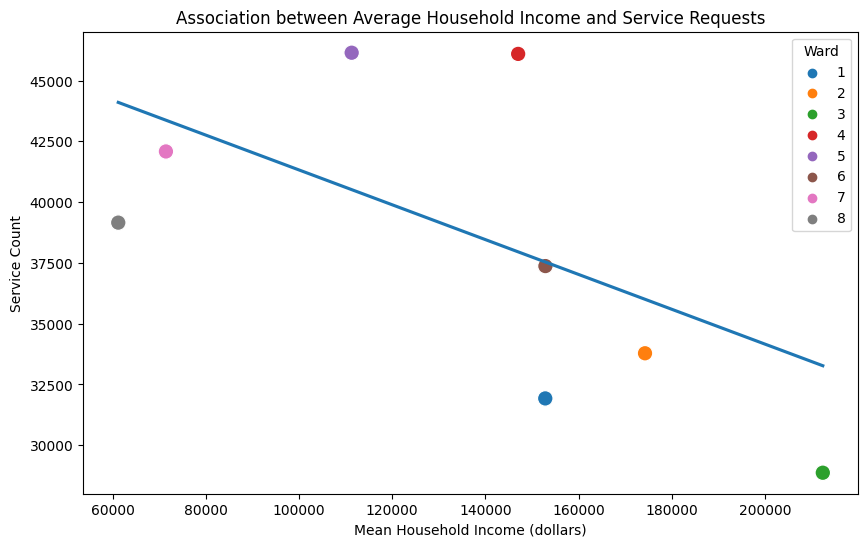

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'Mean_household_income_dollars', y = 'Service_count', data = final_df)
sns.scatterplot(data=final_df, x='Mean_household_income_dollars', y='Service_count', hue = 'Ward', s = 125)
plt.title('Association between Average Household Income and Service Requests')
plt.xlabel('Mean Household Income (dollars)')
plt.ylabel('Service Count')
plt.show()

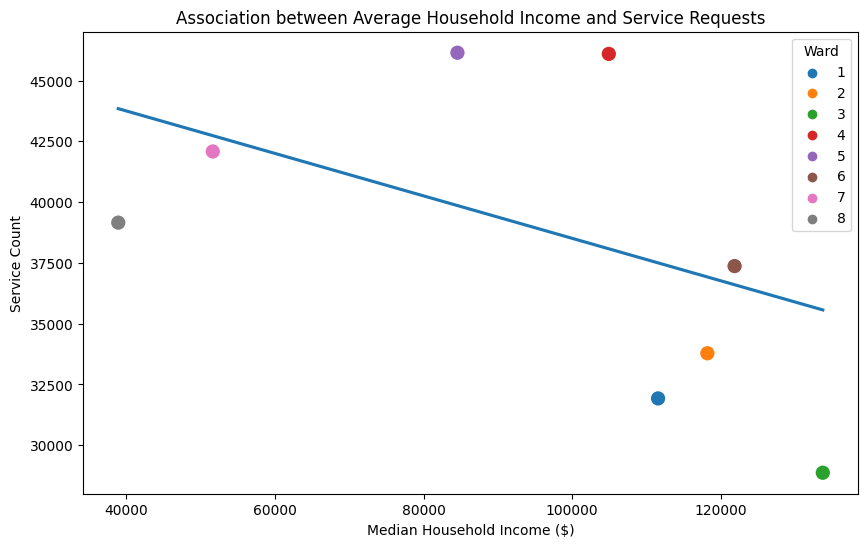

In [28]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'Median_household_income_dollars', y = 'Service_count', data = final_df)
sns.scatterplot(data=final_df, x='Median_household_income_dollars', y='Service_count', hue = 'Ward', s = 125)
plt.title('Association between Average Household Income and Service Requests')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Service Count')
plt.show()

*Research Questions: 2 & 3*

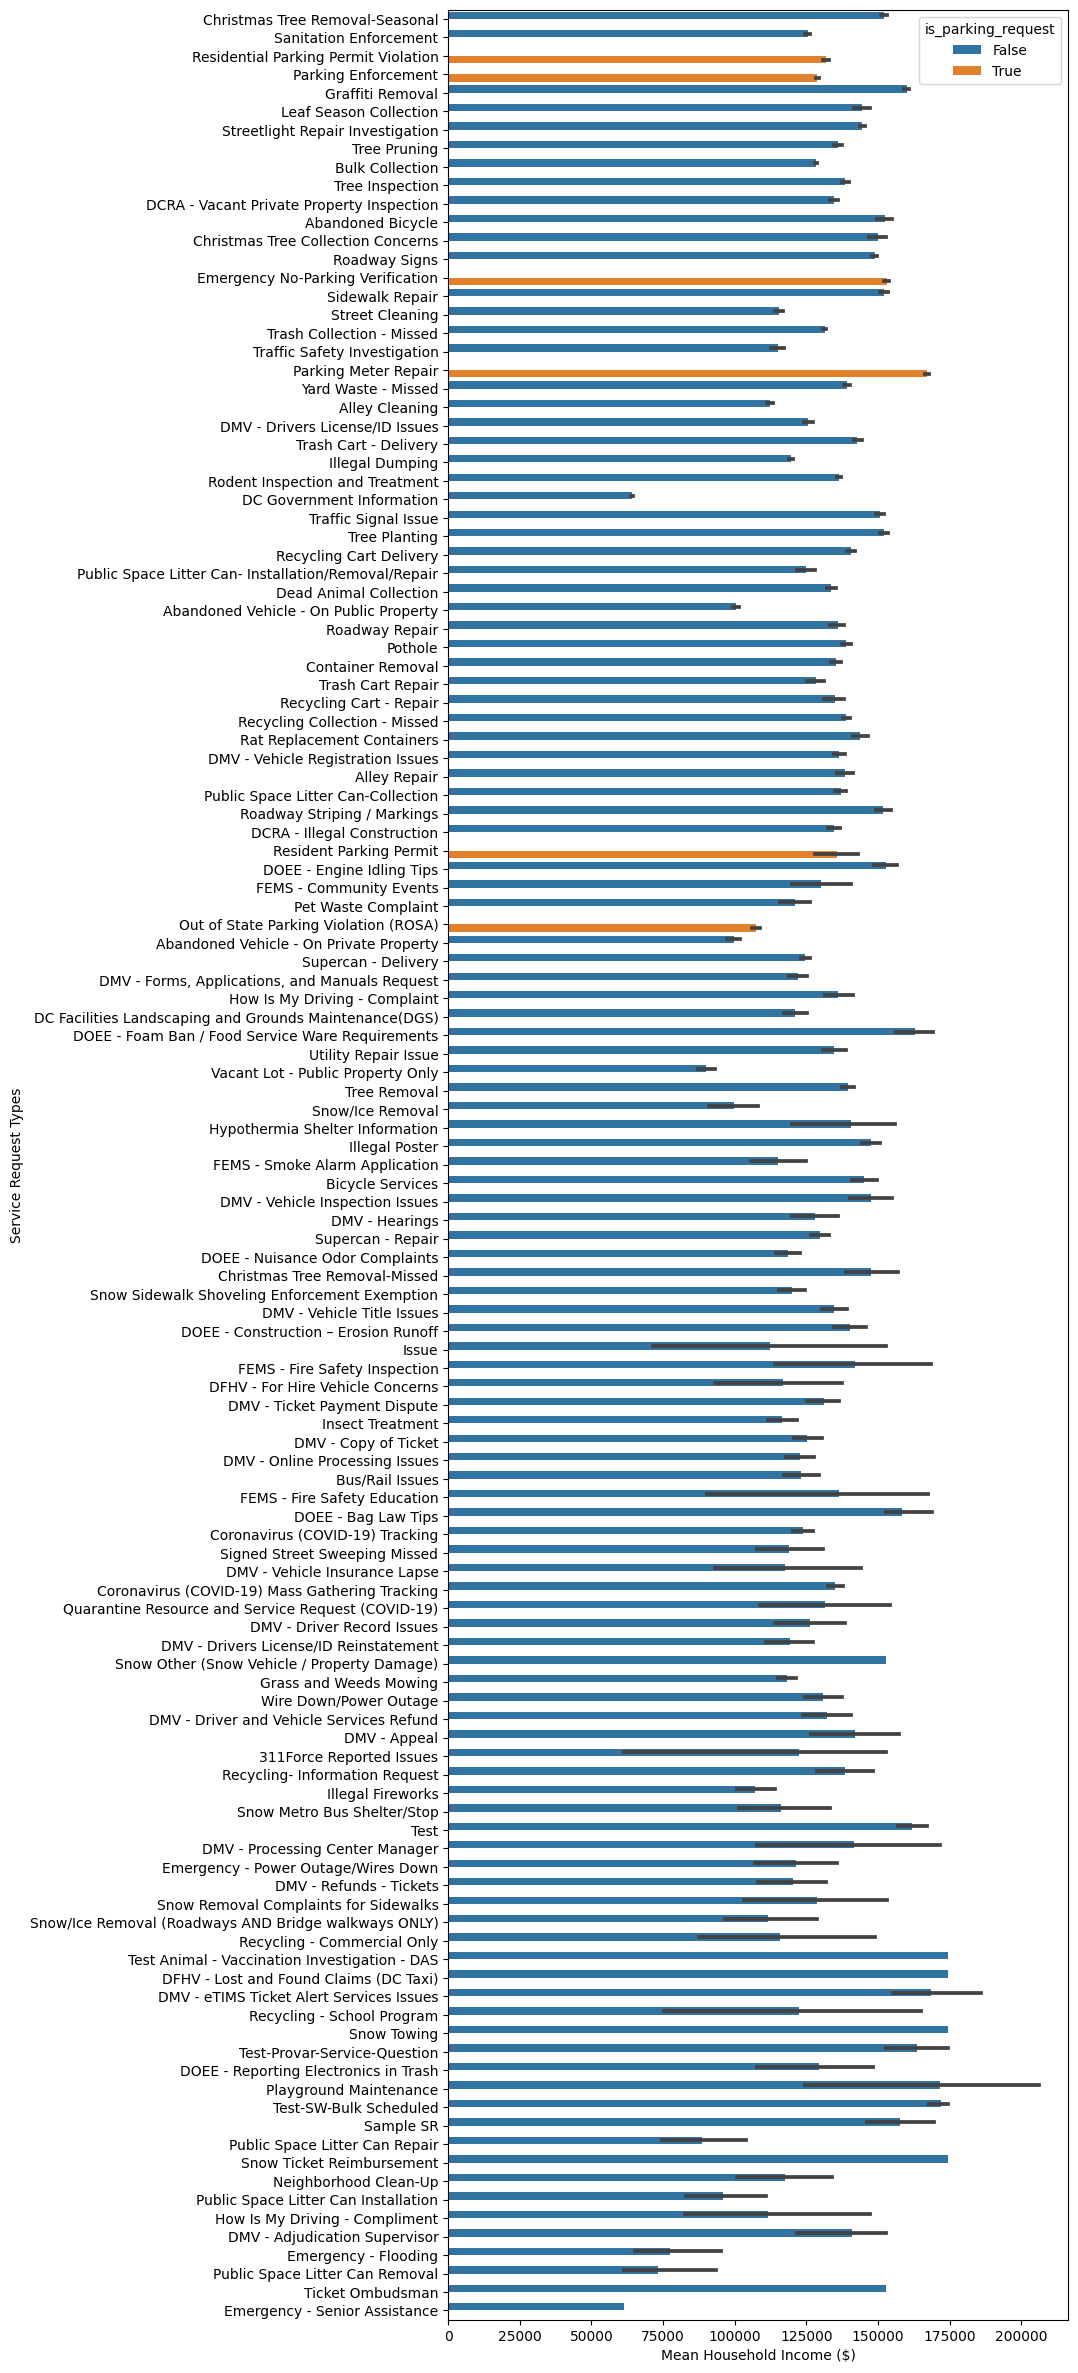

In [29]:
plt.figure(figsize=(8, 30))
sns.barplot(x='Mean_household_income_dollars', y='Service_code_description', hue='is_parking_request', data=final_df)
plt.xlabel('Mean Household Income ($)')
plt.ylabel('Service Request Types')
plt.show()

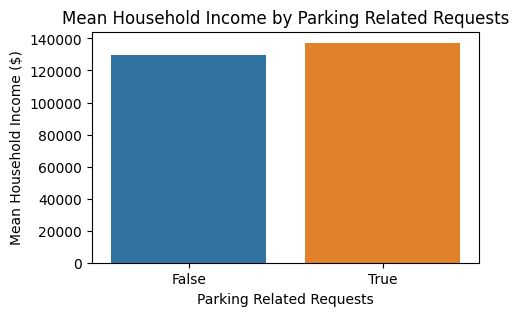

In [30]:
mean_income_by_parking = final_df.groupby('is_parking_request')['Mean_household_income_dollars'].mean().reset_index()

plt.figure(figsize=(5, 3))
sns.barplot(x='is_parking_request', y='Mean_household_income_dollars', data=mean_income_by_parking)
plt.title('Mean Household Income by Parking Related Requests')
plt.xlabel('Parking Related Requests')
plt.ylabel('Mean Household Income ($)')
plt.show()


*Research Question: 4*

In [31]:
numeric_columns = final_df.select_dtypes(include=['float64', 'int64'])

correlation = numeric_columns.corr()
correlation

,Mean_household_income_dollars,Median_household_income_dollars,Service_count
Mean_household_income_dollars,1.000000,0.971511,-0.562768
Median_household_income_dollars,0.971511,1.000000,-0.469393
Service_count,-0.562768,-0.469393,1.000000


(array([81237.,     0.,     0., 46143.,     0., 46095., 69293., 33782.,
            0., 28869.]),
 array([ 61229. ,  76347.4,  91465.8, 106584.2, 121702.6, 136821. ,
        151939.4, 167057.8, 182176.2, 197294.6, 212413. ]),
 <BarContainer object of 10 artists>)

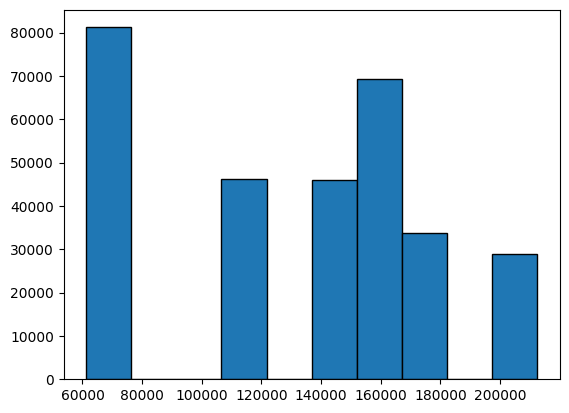

In [32]:
# looking at distribution
plt.hist(final_df['Mean_household_income_dollars'], bins=10, edgecolor='black')

(array([39155., 42082.,     0.,     0., 46143.,     0., 46095., 31925.,
        71150., 28869.]),
 array([ 38906. ,  48390.4,  57874.8,  67359.2,  76843.6,  86328. ,
         95812.4, 105296.8, 114781.2, 124265.6, 133750. ]),
 <BarContainer object of 10 artists>)

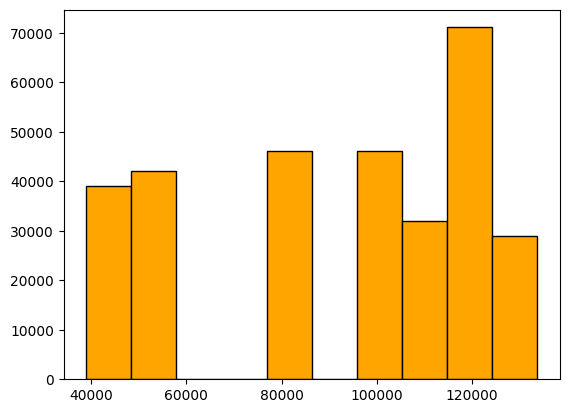

In [33]:
plt.hist(final_df['Median_household_income_dollars'], bins=10, color='orange', edgecolor='black')

4. Findings

a. The association between the average household income and service requests. 
- For both the median and the mean household income, there seems to be a negative linear relationship between the predictors and the amount of service requested. This means the higher the income, the fewer the service requested.
- Correlation coefficient measures the strength of a linear association between the predictors and the response. They range from -1 < r < 1. We see that the correlation between both the median and mean household income separately are low (-0.469 and -0.562 respectively), indicating a weak relationship. We should also note that if we were to fit both the median and mean household income together as a multiple linear regression, because these two predictors are highly correlated (0.971511), the slope would be deflated. 
- In order to find if there is a significant relationship between the mean household income and the service requested as well as between the median household income and the service requested, we can run a hypothesis test for both. 

In [34]:
y= final_df['Service_count']
X= final_df['Mean_household_income_dollars']

# Define model
model = sm.OLS(y, X) 

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          Service_count   R-squared (uncentered):                   0.817
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                          1.362e+06
Date:                Wed, 17 Apr 2024   Prob (F-statistic):                        0.00
Time:                        13:23:04   Log-Likelihood:                     -3.4072e+06
No. Observations:              305419   AIC:                                  6.814e+06
Df Residuals:                  305418   BIC:                                  6.814e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

- Model A: y = Bo + B1x1 --> Mean household income 
- Hypotheses for model A --> Ho: B1 = 0 and Ha: B1 ≠ 0
- Test statistic for model A --> t = 1167.050
- Decision for model A --> Reject Ho b/c p-val (0.000) < α (5%). Hence, there is a significant relationship between the service requested and the mean household income. 

In [35]:
y= final_df['Service_count']
X= final_df['Median_household_income_dollars']

model = sm.OLS(y, X) 

results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          Service_count   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                          1.532e+06
Date:                Wed, 17 Apr 2024   Prob (F-statistic):                        0.00
Time:                        13:23:04   Log-Likelihood:                     -3.3924e+06
No. Observations:              305419   AIC:                                  6.785e+06
Df Residuals:                  305418   BIC:                                  6.785e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

- Model B: y = Bo + B2x2 --> Median household income 
- Hypotheses for model A --> Ho: B2 = 0 and Ha: B2 ≠ 0
- Test statistic for model A --> t = 1237.686
- Decision for model A --> Reject Ho b/c p-val (0.000) < α (5%). Hence, there is a significant relationship between the service requested and the median household income. 

b. The better measure: mean vs. median
- As mentioned earlier, the mean is affected by significant outliers. The median, on the other hand, is less sensitive to outliers. Since the distribution of both the median household income and the mean household income seems very slighly skewed, the median may be a better measure. Additionally, practically, given that there could be outliers that influence the relationship between the average household income and the demand for service, the median may be a better measure. 

c. Parking vs. Non-parking related requests
- With all types of non-parking related and parking related requests combined, there is more non-parking related requests made by the wards in DC than parking-related requests. However, it is worth noting that the difference between the two is really small. Additionally, the average household income for both parking-related and non-parking related requests is approximately between 120,000 U.S. dollars and 130,000 U.S. dollars. 

5. Limitations

- The analysis focuses solely on the association between average household income and service requests, without considering other potentially relevant factors such as population demographics, household composition, or local characteristics. 
- The analysis does not focus on the trend over time in different wards and the differnet types of service requests made. 
- The analysis only finds the association between variables and not causation.

6. Conclusion

Takeaway message
- The significant relationship between average household income and service requests suggests that socioeconomic factors, such as income, play a role in determining the demand for services. This could be highly beneficial for service providers to target different wards in DC effectively in times of need. Additionally, since communities who earn more demand less services, this could be helpful in the developing strategies to allocate resources for different wards more efficiently. 
-  The small difference in demand for service indicates that parking-related issues are also significant concerns for residents. Additionally, since the difference between the average household income for parking-related and non-parking related requests is not very broad, this implies that besides income, there are other factors such as population per ward, local policies, etc. that influence the service requests. 